## 策略逻辑：
60分钟看长短期MA趋势， 15分钟做均线择时。

In [10]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 20; slowPeriod = 55
    signalMaPeriod = 20
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod',
                 'signalMaPeriod'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        pass
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        pass
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎回测

In [11]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180901 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000001DD1D5F7048>, <__main__.MultiFrameMaStrategy object at 0x000001DD1AF658D0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000001DD1D5F7488>, <__main__.MultiFrameMaStrategy object at 0x000001DD1AF658D0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000001DD1D5F70D0>, <__main__.MultiFrameMaStrategy object at 0x000001DD1AF658D0>)
2018-11-27 16:39:09.948907	开始回测
2018-11-27 16:39:09.948907	策略初始化
2018-11-27 16:39:09.949906	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-11-27 16:39:10.528314	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 16:39:10.532311	载入完成，数据量：12000
2018-11-27 16:39:10.533309	策略初始化完成
2018-11-27 16:39:10.533309	策略启动完成
2018-11-27 16:39:10.533309	开始回放回测数据,回测范围:[20180901 12:00,20

In [12]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-14 21:00:00,空,,,0.0,,开仓,67,,6364.47,0.0,None,,,67,2018-11-14 21:00:00,1,67,BTCUSDT:binance,67
2018-11-18 20:30:00,多,,,0.0,,平仓,68,,5649.06,0.0,None,,,68,2018-11-18 20:30:00,1,68,BTCUSDT:binance,68
2018-11-18 20:30:00,多,,,0.0,,开仓,69,,5649.06,0.0,None,,,69,2018-11-18 20:30:00,1,69,BTCUSDT:binance,69
2018-11-19 15:00:00,空,,,0.0,,平仓,70,,5468.68,0.0,None,,,70,2018-11-19 15:00:00,1,70,BTCUSDT:binance,70
2018-11-19 15:00:00,空,,,0.0,,开仓,71,,5468.68,0.0,None,,,71,2018-11-19 15:00:00,1,71,BTCUSDT:binance,71


## 查看绩效与优化

2018-11-27 16:39:28.106324	计算按日统计结果
2018-11-27 16:39:28.125304	------------------------------
2018-11-27 16:39:28.125304	首个交易日：	2018-09-01 00:00:00
2018-11-27 16:39:28.125304	最后交易日：	2018-11-23 00:00:00
2018-11-27 16:39:28.125304	总交易日：	84
2018-11-27 16:39:28.125304	盈利交易日	54
2018-11-27 16:39:28.125304	亏损交易日：	29
2018-11-27 16:39:28.125304	起始资金：	1000000
2018-11-27 16:39:28.125304	结束资金：	1,003,343.23
2018-11-27 16:39:28.125304	总收益率：	0.33%
2018-11-27 16:39:28.125304	年化收益：	0.96%
2018-11-27 16:39:28.125304	总盈亏：	3,343.23
2018-11-27 16:39:28.125304	最大回撤: 	-308.75
2018-11-27 16:39:28.125304	百分比最大回撤: -0.03%
2018-11-27 16:39:28.125304	总手续费：	230.16
2018-11-27 16:39:28.125304	总滑点：	0.14
2018-11-27 16:39:28.125304	总成交金额：	460,323.2
2018-11-27 16:39:28.125304	总成交笔数：	71
2018-11-27 16:39:28.125304	日均盈亏：	39.8
2018-11-27 16:39:28.125304	日均手续费：	2.74
2018-11-27 16:39:28.125304	日均滑点：	0.0
2018-11-27 16:39:28.125304	日均成交金额：	5,480.04
2018-11-27 16:39:28.125304	日均成交笔数：	0.85
2018-11-27 16:39:28.125304	日均收益率：	0.0%
201

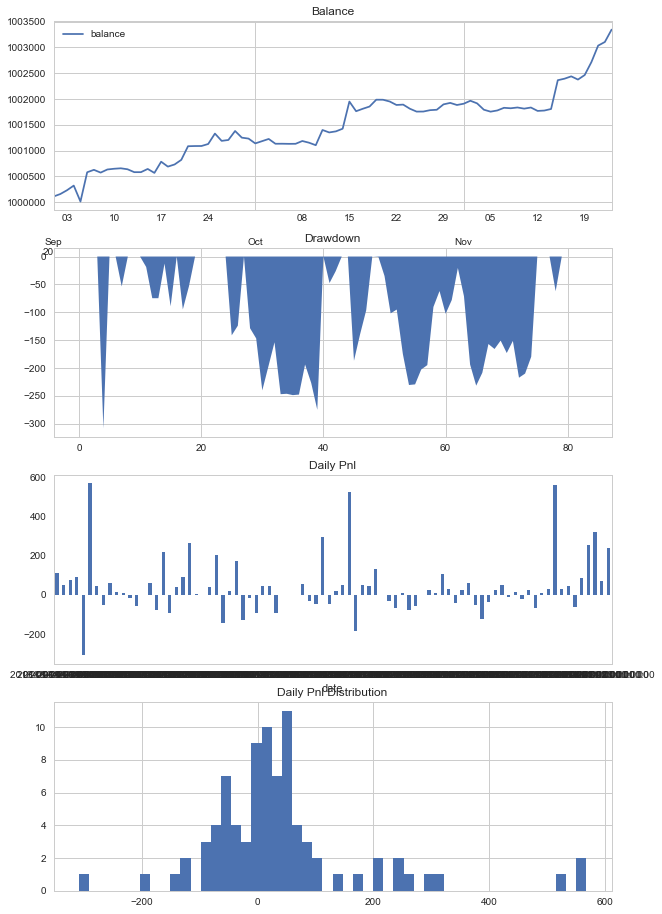

In [13]:
# 显示逐日回测结果
engine.showDailyResult()

2018-11-27 16:39:29.634764	计算回测结果
2018-11-27 16:39:29.637760	------------------------------
2018-11-27 16:39:29.638759	第一笔交易：	2018-09-05 22:00:00
2018-11-27 16:39:29.638759	最后一笔交易：	2018-11-23 11:58:00
2018-11-27 16:39:29.638759	总交易次数：	36
2018-11-27 16:39:29.638759	总盈亏：	3,341.06
2018-11-27 16:39:29.638759	最大回撤: 	-254.65
2018-11-27 16:39:29.638759	平均每笔盈利：	92.81
2018-11-27 16:39:29.638759	平均每笔滑点：	0.0
2018-11-27 16:39:29.638759	平均每笔佣金：	6.45
2018-11-27 16:39:29.638759	胜率		36.11%
2018-11-27 16:39:29.638759	盈利交易平均值	339.84
2018-11-27 16:39:29.638759	亏损交易平均值	-46.82
2018-11-27 16:39:29.638759	盈亏比：	7.26


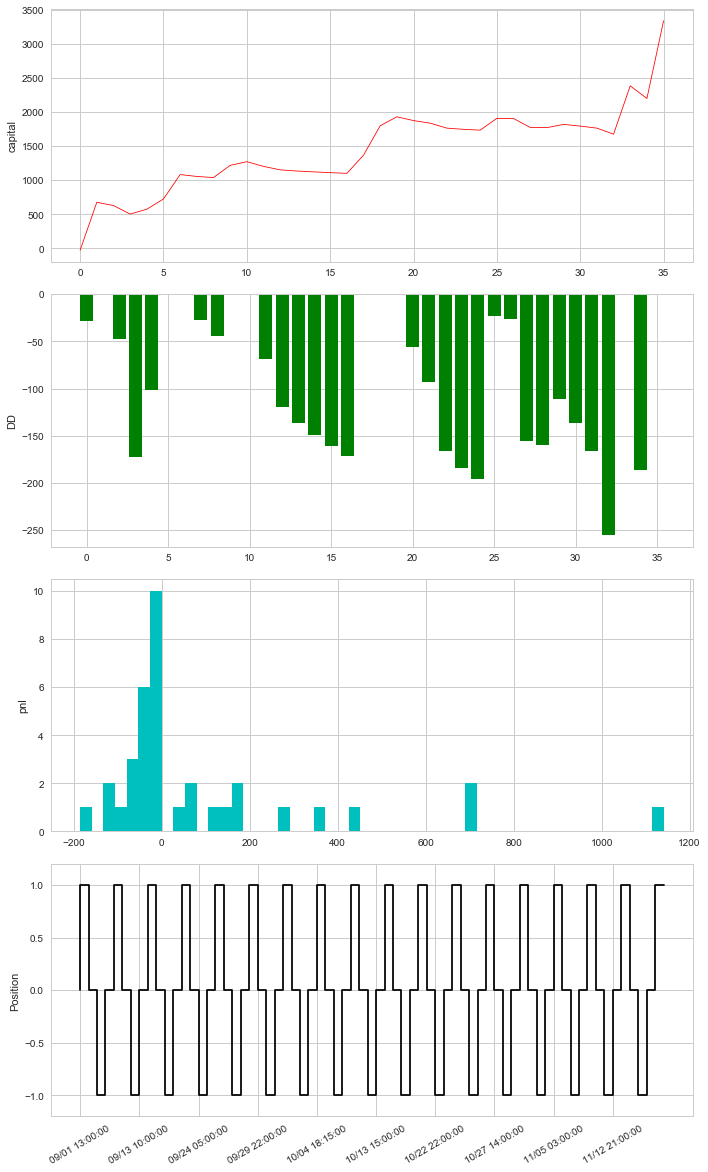

In [14]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [15]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)
print(pd.Series(result))

2018-11-27 16:39:30.319064	计算按日统计结果
annualizedReturn               0.955208
dailyCommission                 2.74002
dailyNetPnl                     39.8003
dailyReturn                  0.00384366
dailySlippage                0.00169048
dailyTradeCount                0.845238
dailyTurnover                   5480.04
endBalance                  1.00334e+06
endDate             2018-11-23 00:00:00
lossDays                             29
maxDdPercent                 -0.0308648
maxDrawdown                    -308.747
profitDays                           54
returnStd                     0.0140566
sharpeRatio                     4.23614
startDate           2018-09-01 00:00:00
totalCommission                 230.162
totalDays                            84
totalNetPnl                     3343.23
totalReturn                    0.334323
totalSlippage                     0.142
totalTradeCount                      71
totalTurnover                    460323
dtype: object


In [16]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod', 20, 40, 10)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod', 40, 80, 20)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-11-27 16:40:04.320387	------------------------------
2018-11-27 16:40:04.320387	setting: {'fastPeriod': 20, 'slowPeriod': 40, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000001DD1D2C3D08>, <__main__.MultiFrameMaStrategy object at 0x000001DD1889CF60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000001DD1D2F0D08>, <__main__.MultiFrameMaStrategy object at 0x000001DD1889CF60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000001DD184AAC80>, <__main__.MultiFrameMaStrategy object at 0x000001DD1889CF60>)
2018-11-27 16:40:04.355352	开始回测
2018-11-27 16:40:04.355352	策略初始化
2018-11-27 16:40:04.356352	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-11-27 16:40:04.849847	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018

2018-11-27 16:40:45.045683	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 16:40:45.100628	载入完成，数据量：118890
2018-11-27 16:40:45.101627	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-11-27 16:40:45.104623	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-11-27 16:40:45.321402	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 16:40:45.323400	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-11-27 16:40:45.350371	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-11-27 16:40:47.697571	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 16:40:47.724544	载入完成，数据量：53630
2018-11-27 16:40:47.734533	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-11-27 16:40:47.785481	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 16:40:47.786480	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-11-27 16:42:09.813300	数据回放结束ss: 100%    
2018-11-27 16:42:09.813300	计算按日统计结果
2018-11-27 16:42:09.890221	------------------------------
2018-11-27 16:42:09.891221	setting: {'fastPeriod': 40, 'slowPeriod': 60, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000001DD1DAA70D0>, <__main__.MultiFrameMaStrategy object at 0x000001DD19CCFC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000001DD1DAA7E18>, <__main__.MultiFrameMaStrategy object at 0x000001DD19CCFC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000001DD1DAA7BF8>, <__main__.MultiFrameMaStrategy object at 0x000001DD19CCFC50>)
2018-11-27 16:42:09.932178	开始回测
2018-11-27 16:42:09.932178	策略初始化
2018-11-27 16:42:09.934176	载入历史数据。数据范围:[20180824 04:00,2

### 打印最优结果排序的DataFrame

In [17]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                   0         1  \
0  [{'fastPeriod': 20, 'slowPeriod': 40, 'symbolL...  3.837318   
1  [{'fastPeriod': 20, 'slowPeriod': 60, 'symbolL...  3.750638   
2  [{'fastPeriod': 30, 'slowPeriod': 40, 'symbolL...  3.642567   
3  [{'fastPeriod': 20, 'slowPeriod': 80, 'symbolL...  3.533242   
4  [{'fastPeriod': 40, 'slowPeriod': 40, 'symbolL...  3.117938   
5  [{'fastPeriod': 30, 'slowPeriod': 80, 'symbolL...  2.945659   
6  [{'fastPeriod': 30, 'slowPeriod': 60, 'symbolL...  2.919580   
7  [{'fastPeriod': 40, 'slowPeriod': 60, 'symbolL...  2.633919   
8  [{'fastPeriod': 40, 'slowPeriod': 80, 'symbolL...  2.458460   

                                                   2  
0  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
1  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
2  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
3  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
4  {'startDate': 2018-09-01 00:00:00, 'endDate': ...  
5  {'star

In [18]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'fastPeriod': 20, 'slowPeriod': 40, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.8373178980181555
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：43
lossDays：40
endBalance：1002162.8486499999
maxDrawdown：-800.1604799999623
maxDdPercent：-0.0802844900912358
totalNetPnl：2162.8486499999967
dailyNetPnl：25.748198214285676
totalCommission：366.11134999999996
dailyCommission：4.358468452380952
totalSlippage：0.23000000000000015
dailySlippage：0.00273809523809524
totalTurnover：732222.7000000001
dailyTurnover：8716.936904761906
totalTradeCount：115
dailyTradeCount：1.369047619047619
totalReturn：0.21628486500000488
annualizedReturn：0.617956757142871
dailyReturn：0.009231223526044257
returnStd：0.037268087692137686
sharpeRatio：3.8373178980181555
------------------------------
参数：["{'fastPeriod': 20, 'slowPeriod': 60, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.7506375116750355
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00